In [1]:
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

# Modelo de Ising

## Funciones Auxiliares

### Definieindo el Campo de Espines

In [2]:
def create_random_spin_grid(N):
    """
    Crea grid cuadrado 2D de NxN con entradas -1 y 1 aleatoriamente

    Parámetros:
    - N: Dimensión.

    Retorna:
    - Matriz(array) con entradas -1 y 1 aleatorias y dimensión N
    """
    return np.random.choice([-1,1], size=(N,N))

def ising_update(grid, N, M, beta):
    """
    Actualización del Campo de Espines en la entrada N,M

    Parámetros:
    - grid: Matriz de cuadrada (con entradas -1 y 1)
    - N: posición horizontal del punto de interes
    - N: posición vertical del punto de interes
    - beta: constante (inversamente proporcional a la T del sistema)

    Retorna:
    - grid: Matriz con la entrada N,M actualizada
    - old_grid: Matriz inicial
    """
    total = 0
    old_grid = np.copy(grid)
    _N, _M = grid.shape
    for i in range(N-1, N+2): #vecinos en n
        for j in range(M-1, M+2): #vecinos en m (incluidos el punto)
            if i == N and j == M: #quitar el mismo punto
                continue
            total += grid[i%_N, j%_M] 
        dE = 2*grid[N,M]*total
        if dE<=0:
            grid[N,M] *= -1
        elif np.exp(-dE*beta)>np.random.rand():
            grid[N,M] *= -1
    return grid, old_grid

def ising_step(grid, beta):
    """
    Actualización en cada los puntos del Campo de Espines

    Parámetros:
    - grid: Una matriz bidimensional que representa el estado del sistema
    - beta: constante (inversamente proporcional a la T del sistema)

    Retorna:
    - new_grid: Matriz actualizada en cada entrada
    """
    new_grid = grid
    N, M = new_grid.shape
    for i in range(N):
        for j in range(M):
            new_grid, old_gridd = ising_update(new_grid, i, j, beta)
    return new_grid

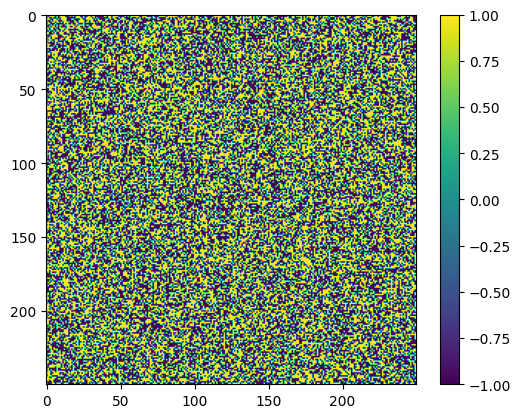

In [3]:
grid = create_random_spin_grid(250)

# Visualize the grid 
plt.imshow(grid)
plt.colorbar()
plt.show()

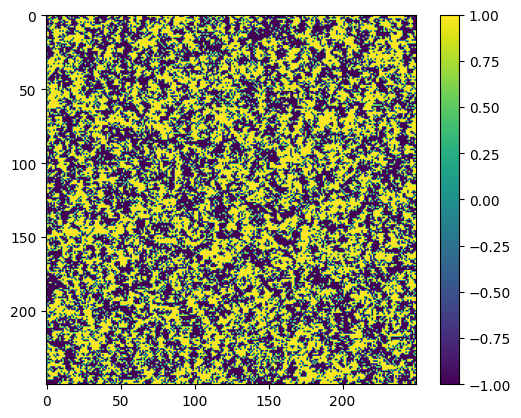

In [4]:
# Después de usar el modelo de Ising una vez
ising_step(grid, 0.2)

# Visualize the grid 
plt.imshow(grid)
plt.colorbar()
plt.show()

### Calculando la Energía Total del Sistema

In [5]:
def energia(grid):
    """
    Calcula la energía del sistema basada en el modelo de Ising.

    Parámetros:
    - grid: Una matriz bidimensional que representa el estado del sistema, donde los elementos son +1 o -1.

    Retorna:
    - energía: La energía total del sistema.
    """

    row, col = len(grid), len(grid[0])
    energia = 0
    # Calcular la energía para los enlaces horizontales
    for i in range(row):
        for j in range(col - 1):
            energia += -1*grid[i][j] * grid[i][j + 1]

    # Calcular la energía para los enlaces verticales
    for i in range(row - 1):
        for j in range(col):
            energia += -1*grid[i][j] * grid[i + 1][j]
    return energia

## Optimización con Cython

Tomada de https://jakevdp.github.io/blog/2017/12/11/live-coding-cython-ising-model/

In [6]:
%load_ext Cython

In [7]:
%%cython

cimport cython

import numpy as np
cimport numpy as np

from libc.math cimport exp
from libc.stdlib cimport rand
cdef extern from "limits.h":
    int RAND_MAX


@cython.boundscheck(False)
@cython.wraparound(False)
def cy_ising_step(np.int64_t[:, :] field, float beta=0.4):
    cdef int N = field.shape[0]
    cdef int M = field.shape[1]
    cdef int n_offset, m_offset, n, m
    for n_offset in range(2):
        for m_offset in range(2):
            for n in range(n_offset, N, 2):
                for m in range(m_offset, M, 2):
                    _cy_ising_update(field, n, m, beta)
    return np.array(field)


@cython.boundscheck(False)
@cython.wraparound(False)
cdef _cy_ising_update(np.int64_t[:, :] field, int n, int m, float beta):
    cdef int total = 0
    cdef int N = field.shape[0]
    cdef int M = field.shape[1]
    cdef int i, j
    for i in range(n-1, n+2):
        for j in range(m-1, m+2):
            if i == n and j == m:
                continue
            total += field[i % N, j % M]
    cdef float dE = 2 * field[n, m] * total
    if dE <= 0:
        field[n, m] *= -1
    elif exp(-dE * beta) * RAND_MAX > rand():
        field[n, m] *= -1

In [8]:
be = 0.2 # 0.2, 0.44 y 0.9 son los valores tomados
images = [create_random_spin_grid(250)] # Generar aleatoriamente una matriz de estados
energy_list = [] # Lista en la que se guardará la energía total del sistema

for i in tqdm(range(1000000)): # se harán 1.000.000 de iteraciones :o
    cy_ising_step(images[-1].copy(), be) # Hacer Ising 1 vez en cada punto de la Matriz images
    
    if i%1000 == 0: # Guardar valores de Energía y Estado (Matriz) cada 1000 iteraciones
        energy_list.append(energia(images[-1]))
        images.append(cy_ising_step(images[-1].copy(), be))

100%|████████████████████████████████| 1000000/1000000 [22:47<00:00, 731.47it/s]


### Proceso de Exportación de las Imagenes

In [11]:
from PIL import Image

def display_spin_field(field):
    return Image.fromarray(np.uint8((field + 1) * 0.5 * 255))  # 0 ... 255

display_spin_field(create_random_spin_grid(200))

export = np.copy(images)
image_list = [Image.fromarray(np.uint8((export[i]+1) * 0.5 * 255))for i in range(len(export)) ]

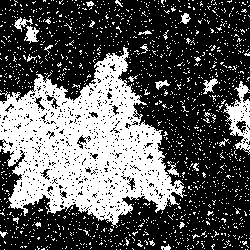

In [13]:
image_list[-1]

In [ ]:
# Guardar .gif
image_list[0].save(
            'animation_faster.gif',
            save_all=True,
            append_images=image_list[1:], # append rest of the images
            duration=.5, # in milliseconds
            loop=0)

In [ ]:
def save_images(beta):    
    image_list[0].save(f'{beta}image0.jpg')
    #image_list[10].save(f'{beta}image10.jpg')
    #image_list[50].save(f'{beta}image50.jpg')
    #image_list[100].save(f'{beta}image100.jpg')
    image_list[250].save(f'{beta}image250.jpg')
    image_list[500].save(f'{beta}image500.jpg')
    image_list[750].save(f'{beta}image750.jpg')
    image_list[-1].save(f'{beta}image1000.jpg')

In [ ]:
save_images('090')

## Evolución de la Energía

Text(0, 0.5, 'Energía total del sistema')

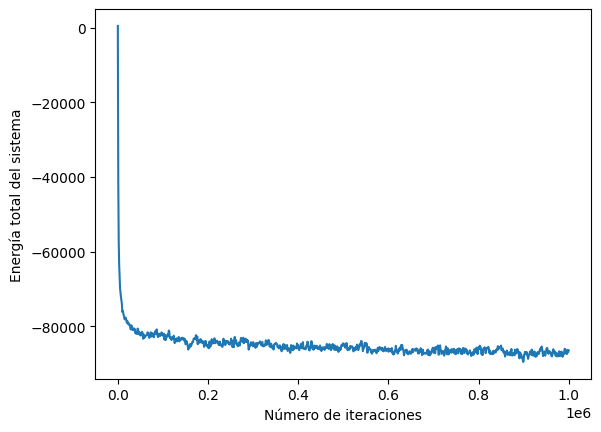

In [14]:
x=np.linspace(0, 1000000, num=len(energy_list))

plt.plot(x, energy_list)


plt.xlabel('Número de iteraciones')
plt.ylabel('Energía total del sistema')